In [1]:
import yfinance as yf
import pandas as pd

In [2]:
ticker = "MNG.L"
time_period = "2y"

price_data = yf.download(ticker, period=time_period, auto_adjust=False)["Close"]
dividend_data = yf.Ticker(ticker).dividends

price_data.index = pd.to_datetime(price_data.index).tz_localize(None)
dividend_data.index = pd.to_datetime(dividend_data.index).tz_localize(None)
dividend_data = dividend_data.loc[price_data.index[0]:]

[*********************100%***********************]  1 of 1 completed


In [3]:
price_dividend_df = pd.concat([price_data,dividend_data], axis=1)
price_dividend_df.columns

Index(['MNG.L', 'Dividends'], dtype='object')

In [4]:
price_dividend_df = price_dividend_df.fillna(0.00)

In [5]:
price_dividend_df.head()

,MNG.L,Dividends
Date,,
2023-05-02,202.800003,0.0
2023-05-03,204.199997,0.0
2023-05-04,199.050003,0.0
2023-05-05,202.899994,0.0
2023-05-09,199.300003,0.0


In [6]:
price_dividend_df["UnadjustedPct"] = price_dividend_df[ticker].pct_change()
price_dividend_df.head()

,MNG.L,Dividends,UnadjustedPct
Date,,,
2023-05-02,202.800003,0.0,NaN
2023-05-03,204.199997,0.0,0.006903
2023-05-04,199.050003,0.0,-0.025220
2023-05-05,202.899994,0.0,0.019342
2023-05-09,199.300003,0.0,-0.017743


In [7]:
# Initialize the Adjustment column with 1s
price_dividend_df["Adjustment"] = 1.0

# List to store the daily a_d values (single-day adjustments)
daily_adjustments = [1.0]  # A_0 is 1

for i in range(1, len(price_dividend_df)):
    dividend = price_dividend_df.iloc[i]["Dividends"]
    prev_close = price_dividend_df.iloc[i - 1][ticker]

    if prev_close == 0:
        daily_adjustments.append(1.0)  # Avoid error, assume no adjustment
        continue

    # a_d = S_d / (1 - D_d / C_{d-1}); assuming S_d = 1 unless specified
    one_day_adj = 1 / (1 - dividend / prev_close)

    # Multiply previous adjustment by today's a_d to get cumulative A_d
    cumulative_adj = daily_adjustments[-1] * one_day_adj

    daily_adjustments.append(cumulative_adj)

# Assign the forward adjustment factor A_d to the DataFrame
price_dividend_df["Adjustment"] = daily_adjustments

In [8]:
price_dividend_df.head()

,MNG.L,Dividends,UnadjustedPct,Adjustment
Date,,,,
2023-05-02,202.800003,0.0,NaN,1.0
2023-05-03,204.199997,0.0,0.006903,1.0
2023-05-04,199.050003,0.0,-0.025220,1.0
2023-05-05,202.899994,0.0,0.019342,1.0
2023-05-09,199.300003,0.0,-0.017743,1.0


In [9]:
price_dividend_df["AdjustedPrices"] = price_dividend_df[ticker]
for i in range(1,len(price_dividend_df)):
    price_dividend_df.at[price_dividend_df.index[i], "AdjustedPrices"] = price_dividend_df.at[price_dividend_df.index[i], ticker] * price_dividend_df.at[price_dividend_df.index[i], "Adjustment"]

In [10]:
import matplotlib.pyplot as plt

In [11]:
price_dividend_df["AdjustedPct"] = price_dividend_df["AdjustedPrices"].pct_change()

In [12]:
price_dividend_df.head()

,MNG.L,Dividends,UnadjustedPct,Adjustment,AdjustedPrices,AdjustedPct
Date,,,,,,
2023-05-02,202.800003,0.0,NaN,1.0,202.800003,NaN
2023-05-03,204.199997,0.0,0.006903,1.0,204.199997,0.006903
2023-05-04,199.050003,0.0,-0.025220,1.0,199.050003,-0.025220
2023-05-05,202.899994,0.0,0.019342,1.0,202.899994,0.019342
2023-05-09,199.300003,0.0,-0.017743,1.0,199.300003,-0.017743


In [13]:
df = price_dividend_df[["AdjustedPct","UnadjustedPct"]]

In [14]:
df = df.dropna()
df

,AdjustedPct,UnadjustedPct
Date,,
2023-05-03,0.006903,0.006903
2023-05-04,-0.025220,-0.025220
2023-05-05,0.019342,0.019342
2023-05-09,-0.017743,-0.017743
2023-05-10,0.001756,0.001756
...,...,...
2025-04-28,0.010309,0.010309
2025-04-29,0.005345,0.005345
2025-04-30,0.002417,0.002417


In [15]:
df["CumAdj"] = (1 + df["AdjustedPct"]).cumprod()
df["CumUnadj"] = (1 + df["UnadjustedPct"]).cumprod()

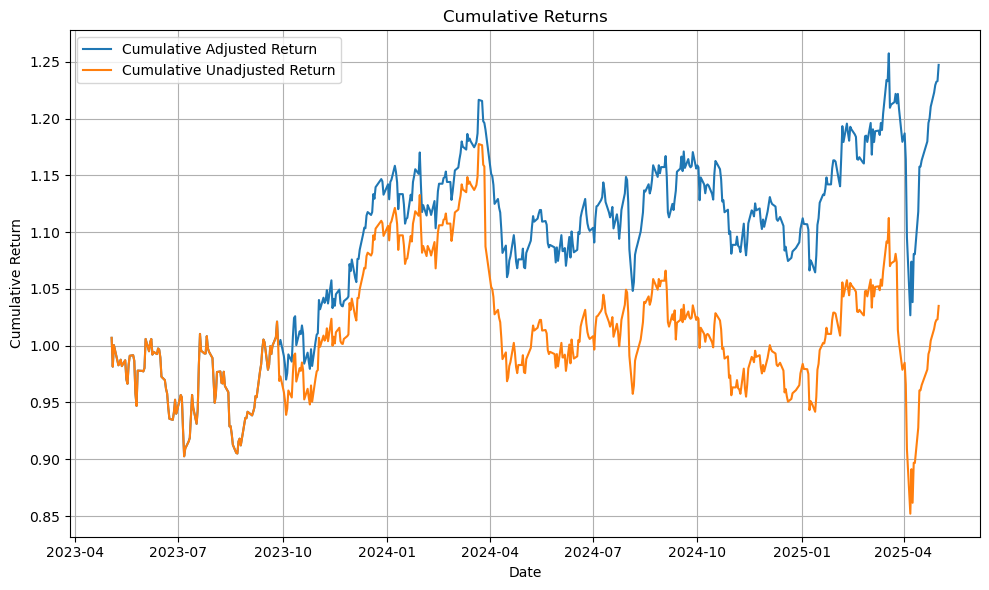

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(df["CumAdj"], label="Cumulative Adjusted Return")
plt.plot(df["CumUnadj"], label="Cumulative Unadjusted Return")
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
df["Spread"] = df["CumAdj"] - df["CumUnadj"]

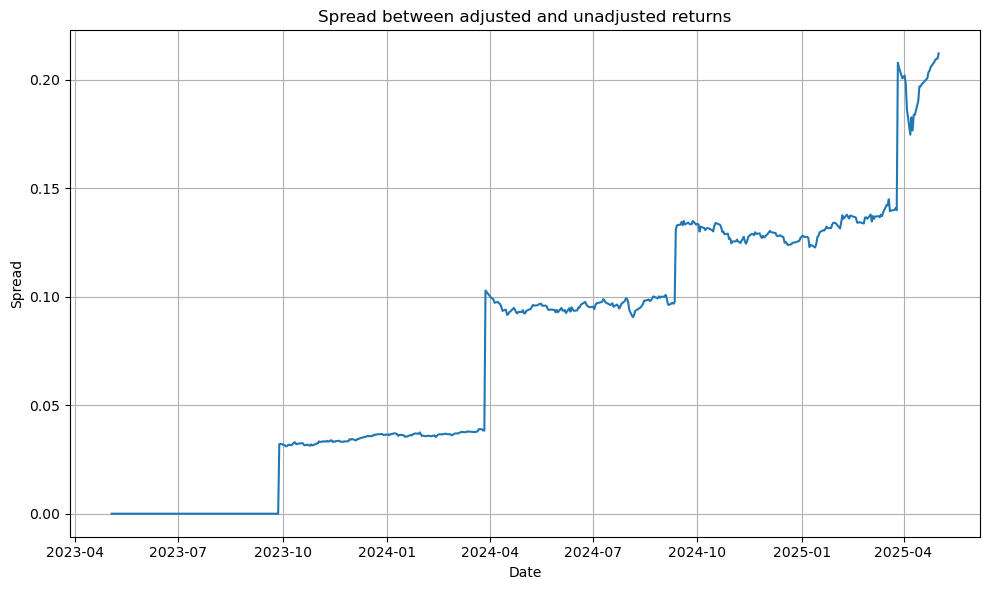

In [18]:
plt.figure(figsize=(10,6))
plt.plot(df["Spread"])
plt.title("Spread between adjusted and unadjusted returns")
plt.xlabel("Date")
plt.ylabel("Spread")
plt.grid(True)
plt.tight_layout()
plt.show()